In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Python version: 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
[GCC 9.3.0]
pandas version: 1.2.2
matplotlib version: 3.4.0
NumPy version: 1.19.5
SciPy version: 1.5.4
IPython version: 7.20.0
scikit-learn version: 0.24.1
-------------------------
titanic



In [3]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
#from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
#Show which values are missing:

print('Train columns with null values:\n', train_data.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum())
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


<AxesSubplot:>

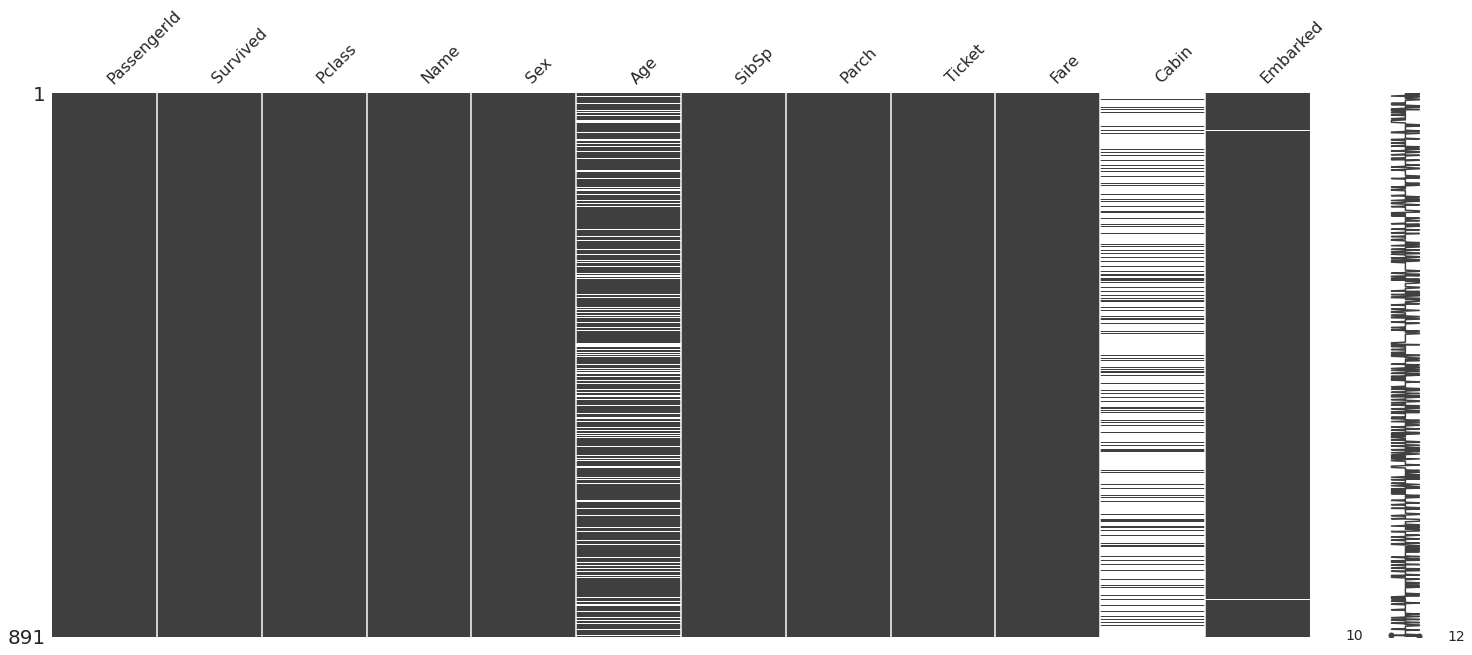

In [7]:
#Visulaizng the missing data:

import missingno as msno
msno.matrix(train_data)

<AxesSubplot:>

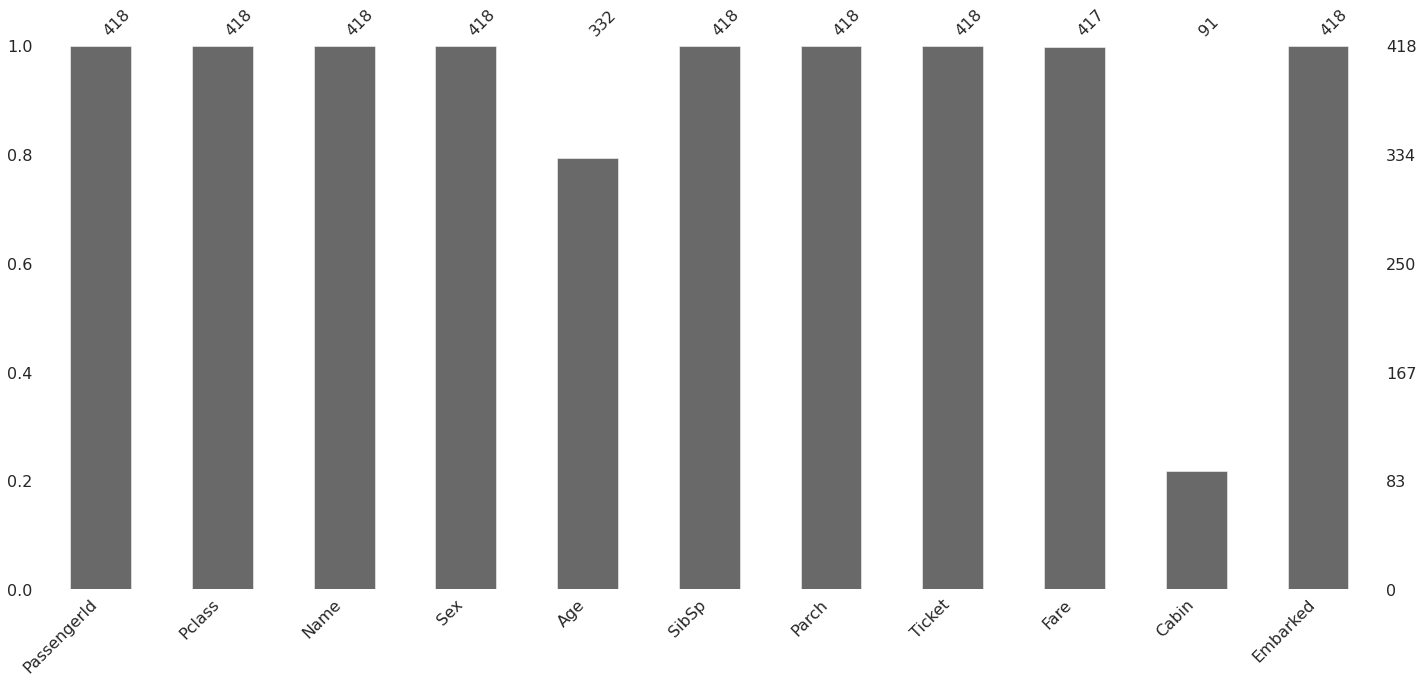

In [8]:
msno.bar(test_data)

In [9]:
y_train = train_data['Survived'].copy()
X_train = train_data.drop(['Survived'], axis=1).copy()
X_test = test_data.copy()

In [10]:
#X feature cleaning:

def feature_cleaning(actual):
    new = actual.copy()
    
    #complete missing age with mean
    new['Age'].fillna(new['Age'].mean(), inplace = True)
    
    #complete embarked with mode
    new['Embarked'].fillna('S', inplace = True)
    
    #complete missing fare with mean
    new['Fare'].fillna(new['Fare'].mean(), inplace = True)
    
    #drop cabin to ignore it, too much missing data not useful feature
    new = new.drop(['Cabin'], axis=1)
    
    #drop passenger ID
    new = new.drop(['PassengerId'], axis=1)
    
    #drop ticket
    new = new.drop(['Ticket'], axis=1)
    
    #Convert category data
    new["Sex"] = new["Sex"].astype('category')
    new["Sex"] = new["Sex"].cat.codes
    new["Embarked"] = new["Embarked"].astype('category')
    new["Embarked"] = new["Embarked"].cat.codes
    
    return new

#then pass the X data through the function:

X_train_clean,X_test_clean=feature_cleaning(X_train),feature_cleaning(X_test)

In [11]:
X_train_clean.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0
2,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2
4,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2


In [12]:
X_test_clean.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",1,34.5,0,0,7.8292,1
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,7.0000,2
2,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,9.6875,1
3,3,"Wirz, Mr. Albert",1,27.0,0,0,8.6625,2
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,12.2875,2


In [13]:
#Sanity check for missing values:

print('Train columns with null values:\n', X_train_clean.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', X_test_clean.isnull().sum())
print("-"*10)

Train columns with null values:
 Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Test/Validation columns with null values:
 Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------


In [14]:
#X feature engineering:
#same process of cleaning, create a function and pass cleaning data through, making a copy of the new engineered data

def feature_engineering(actual):
    new = actual.copy()
    
    def get_title(name):
        return name.split(',')[1].split('.')[0].strip()
    
    new['Title'] = new['Name'].apply(get_title)
    new['Title'] = new['Title'].replace('Mlle', 'Miss')
    new['Title'] = new['Title'].replace('Ms', 'Miss')
    new['Title'] = new['Title'].replace('Mme', 'Mrs')
    
    stat_min = 10
    title_names = (new['Title'].value_counts() < stat_min)
    new['Title'] = new['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    new = new.drop(['Name'], axis=1)
    
    return new

#then pass the X clean data through the function:

X_train_eng,X_test_eng=feature_engineering(X_train_clean),feature_engineering(X_test_clean)

In [15]:
X_train_eng.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,1,22.0,1,0,7.2500,2,Mr
1,1,0,38.0,1,0,71.2833,0,Mrs
2,3,0,26.0,0,0,7.9250,2,Miss
3,1,0,35.0,1,0,53.1000,2,Mrs
4,3,1,35.0,0,0,8.0500,2,Mr


In [16]:
X_test_eng.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,1,34.5,0,0,7.8292,1,Mr
1,3,0,47.0,1,0,7.0000,2,Mrs
2,2,1,62.0,0,0,9.6875,1,Mr
3,3,1,27.0,0,0,8.6625,2,Mr
4,3,0,22.0,1,1,12.2875,2,Mrs


In [17]:
#Scaling data, code categorical data:
#same process of cleaning and engineering, create a function and pass engineering data through, making a copy of the new encoded data

def encoding(actual):
    
    new = actual.copy()
    
    #Fix Fare and Age Bin
    new['Fare'] = pd.qcut(actual['Fare'], 4)
    new['Age'] = pd.cut(actual['Age'].astype(int), 5)
    
    new_1=new.copy()
    
    #label encode all
    label = LabelEncoder()
    for i in actual.columns:
        new_1[i]=label.fit_transform(new[i])
        
    return new_1        
        
X_train_enc,X_test_enc=encoding(X_train_eng),encoding(X_test_eng)

In [18]:
X_train_enc.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,2,1,1,1,0,0,2,3
1,0,0,2,1,0,3,0,4
2,2,0,1,0,0,1,2,2
3,0,0,2,1,0,3,2,4
4,2,1,2,0,0,1,2,3


In [19]:
X_test_enc.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,2,1,2,0,0,0,1,3
1,2,0,3,1,0,0,2,4
2,1,1,4,0,0,1,1,3
3,2,1,1,0,0,1,2,3
4,2,0,1,1,1,1,2,4


In [20]:
#convert y_train into array
#y_train=y_train.values
#print(y_train)

In [21]:
#Exploratory Anaylsis with Statistics on Engineered data:

#Create a new copy of the dataset with x_train_eng and y_train for Exploratory Analysis:

def feature_cleaning_1(actual):
    new = actual.copy()
    
    #complete missing age with mean
    new['Age'].fillna(new['Age'].mean(), inplace = True)
    
    #complete embarked with mode
    new['Embarked'].fillna(new['Embarked'].mode(), inplace = True)
    
    #complete missing fare with mean
    new['Fare'].fillna(new['Fare'].mean(), inplace = True)
    
    #drop cabin to ignore it, too much missing data not useful feature
    new = new.drop(['Cabin'], axis=1)
    
    #drop passenger ID
    new = new.drop(['PassengerId'], axis=1)
    
    #drop ticket
    new = new.drop(['Ticket'], axis=1)
    
    return new

X_train_clean_1=feature_cleaning_1(X_train)

def feature_engineering_1(actual):
    new = actual.copy()
    
    def get_title(name):
        return name.split(',')[1].split('.')[0].strip()
    
    new['Title'] = new['Name'].apply(get_title)
    new['Title'] = new['Title'].replace('Mlle', 'Miss')
    new['Title'] = new['Title'].replace('Ms', 'Miss')
    new['Title'] = new['Title'].replace('Mme', 'Mrs')
    
    stat_min = 10
    title_names = (new['Title'].value_counts() < stat_min)
    new['Title'] = new['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    new = new.drop(['Name'], axis=1)
    
    return new

X_train_eng_1=feature_engineering_1(X_train_clean_1)

data1 = X_train_eng_1.copy()
data1.insert(0,"Survived",y_train,True)
data1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [22]:
#Discrete Variable Correlation by Survival using

#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

x_features =X_train_eng.columns
#['Pclass','Sex','Age','SibSp', 'Parch','Fare', 'Embarked', 'Title']
Target = ['Survived']

for x in x_features:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))


#*Pclass* variable is an ordinal datatype for the ticket class, a proxy for socio-economic status (SES), representing 1 = upper class, 2 = middle class, and 3 = lower class.
#*SibSp* represents number of related siblings/spouse aboard
#*Parch* represents number of related parents/children aboard.
#*Embarked* represents the port of embarkment: 	C = Cherbourg, Q = Queenstown, S = Southampton    

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.347826
2    Miss  0.702703
3      Mr  0.156673
4     Mrs  0.793651
---------- 

Survived    0    1
Title             
Master     17   23
Misc       15    8
Miss      

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

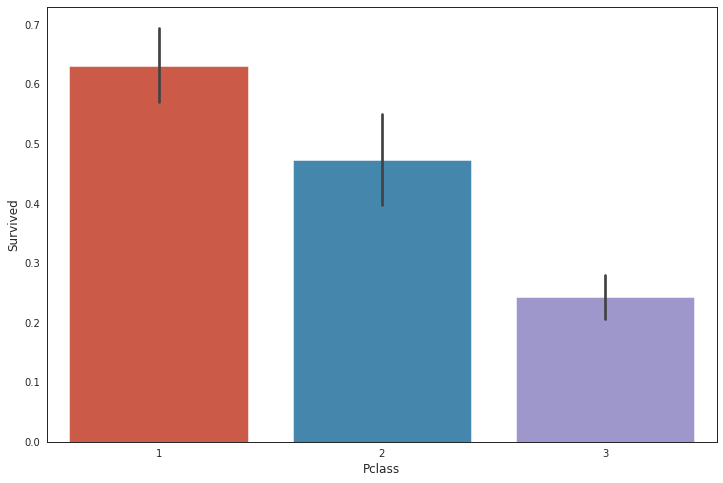

In [23]:
#had a higher change of surviing if you where in P-class 1

sns.barplot(x='Pclass', y='Survived', data=data1)

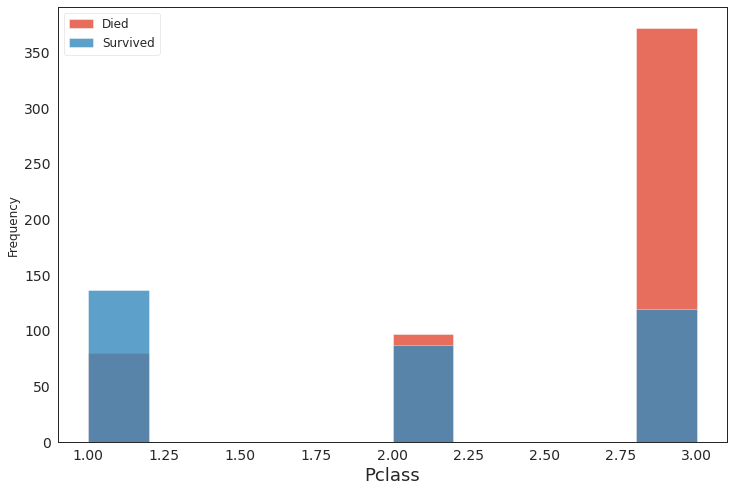

In [24]:
#even though survial rate is higher for Pclass 1, more people in Pclass 1 died compared to class 2 or 3
#chance of survial is still higher in Pclass 1 though...


plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.figure()
fig = data1.groupby('Survived')['Pclass'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Pclass', fontsize = 18)
plt.show()

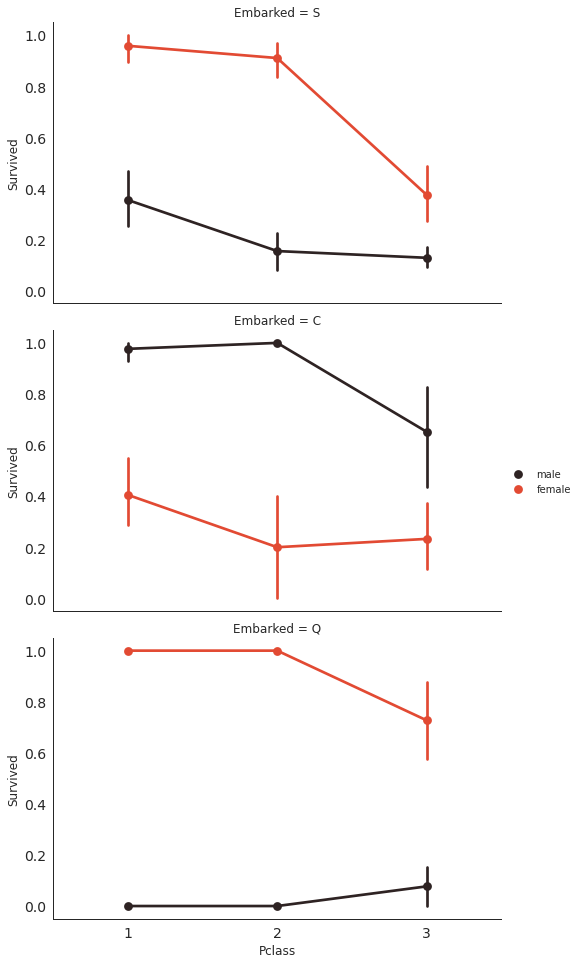

In [25]:
#if you were a female, you had a higher survual rate in all 3 classes from "S" and "Q"
#IF you were a male, you had a higher survival rate in all 3 classes from "C"

FacetGrid = sns.FacetGrid(data1, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

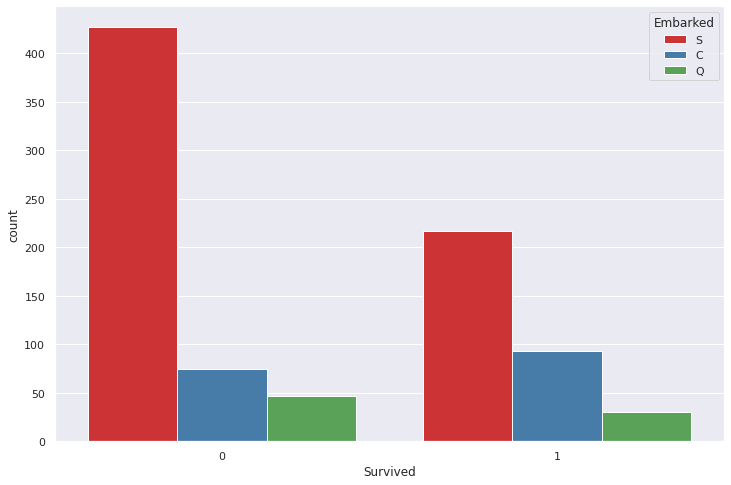

In [26]:
#more people from "S" and "Q" died, opposite for "C"

sns.set(style="darkgrid")
sns.countplot( x='Survived', data=data1, hue="Embarked", palette="Set1");

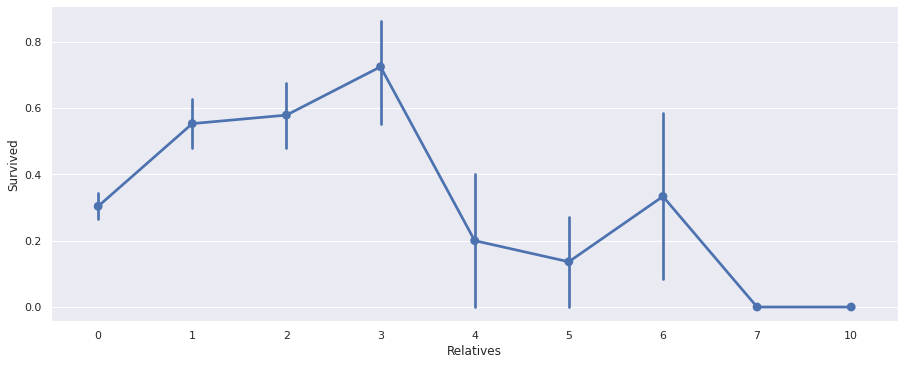

In [27]:
#can create a new tab called "Relatives" with Parch and Sib

#if you had 1-3 relatives, you had a better chance of survial

data1['Relatives'] = data1['SibSp'] + data1['Parch']
data1.loc[data1['Relatives'] > 0, 'travelled_alone'] = 'No'
data1.loc[data1['Relatives'] == 0, 'travelled_alone'] = 'Yes'
axes = sns.factorplot('Relatives','Survived', 
                      data=data1, aspect = 2.5, );

In [28]:
data1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,travelled_alone
0,0,3,male,22.0,1,0,7.2500,S,Mr,1,No
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1,No
2,1,3,female,26.0,0,0,7.9250,S,Miss,0,Yes
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1,No
4,0,3,male,35.0,0,0,8.0500,S,Mr,0,Yes


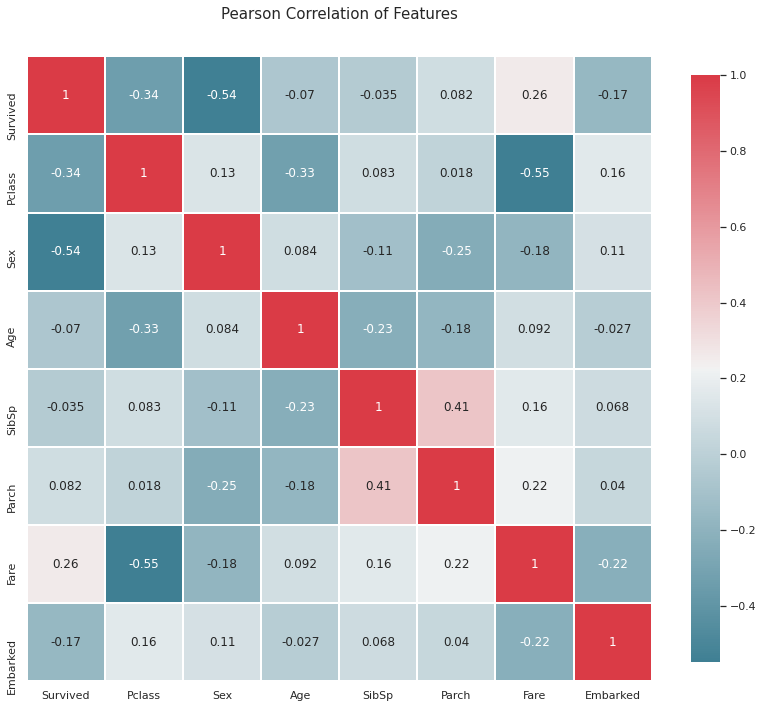

In [29]:
#Create copy of data for correlation analysis
data1_pearson_correlation = X_train_eng.copy()
data1_pearson_correlation.insert(0,"Survived",y_train,True)

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1_pearson_correlation)

#The correlation coefficient has values between -1 to 1
#— A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
#— A value closer to 1 implies stronger positive correlation
#— A value closer to -1 implies stronger negative correlation

# Ensembling and Comparing Machine Learning Algos



In [30]:
#Create a new copy of the dataset with x_train_enc and y_train for Machine Learning:

data_enc=X_train_enc.copy()
data_enc.insert(0,"Survived",y_train,True)

In [31]:
data_enc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,2,1,1,1,0,0,2,3
1,1,0,0,2,1,0,3,0,4
2,1,2,0,1,0,0,1,2,2
3,1,0,0,2,1,0,3,2,4
4,0,2,1,2,0,0,1,2,3


In [32]:
#1.A)Create an empty dataframe to put MLA metrics in

MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#B)#create table to compare MLA predictions

MLA_predict=data1[Target]
MLA_predict.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [33]:
MLA_compare.head()

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time


In [34]:
data_enc[x_features]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,2,1,1,1,0,0,2,3
1,0,0,2,1,0,3,0,4
2,2,0,1,0,0,1,2,2
3,0,0,2,1,0,3,2,4
4,2,1,2,0,0,1,2,3
...,...,...,...,...,...,...,...,...
886,1,1,1,0,0,1,2,1
887,0,0,1,0,0,2,2,2
888,2,0,1,1,2,2,2,2
889,0,1,1,0,0,2,0,3


In [35]:
 data_enc[Target]

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [36]:
#2.Create package of Machine Learning Algos to explore accuracies:

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    XGBClassifier(verbosity=0), #hiding xgboost's output
    CatBoostClassifier(logging_level='Silent') #hiding catboost's output
    ]

#3.split dataset in cross-validation with this splitter class:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = 0.2, train_size = 0.7, random_state = 0 ) # run model 10x with 70/20 split intentionally leaving out 10%
#this cv will be used when we intially evaulte each model


#4. index through MLA and save performance to table

row_index = 0 #this value will update signifying to start the row
for alg in MLA:

    #set name and parameters: filling first 2 columns
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation Kfolds, using the cv we defined earlier:
    cv_results = model_selection.cross_validate(alg, data_enc[x_features], data_enc[Target], cv  = cv_split,return_train_score=True)

    #then we pull the varous results and put them in our table:
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #fit and predict values on the full dataset (training data) - THIS WILL BE USED LATER
    alg.fit(data_enc[x_features], data_enc[Target])
    MLA_predict[MLA_name] = alg.predict(data_enc[x_features])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
8,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.83435,0.836313,0.06706,0.073197
2,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.859551,0.831285,0.083732,0.081822
11,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.891653,0.829609,0.060079,0.065189
12,CatBoostClassifier,{'logging_level': 'Silent'},0.879133,0.826257,0.085606,0.682607
3,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.897432,0.820112,0.056983,0.155371
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.892456,0.816201,0.057791,0.024422
4,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.871108,0.815642,0.1052,0.31873
7,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.849117,0.814525,0.066534,0.004837
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820064,0.812849,0.076528,0.081632
9,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.897432,0.810615,0.062011,0.004396


In [37]:
#more predictor variables do not make a better model, but the right predictors do.
#So another step in data modeling is feature selection. Sklearn has several options, we will use recursive feature elimination (RFE) with cross validation (CV).

In [38]:
#lets choose 1 model for now, SVC:

#1. before Feature Elimination (RFE):

CAT_baseline=CatBoostClassifier(logging_level='Silent',random_state=0)
base_results = model_selection.cross_validate(CAT_baseline, data_enc[x_features], data_enc[Target], cv  = cv_split,return_train_score=True) #this step is bascially just evaluting the results correctly 

#CV logic:
#we used [sklearn cross_validate](http://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation) function to train, test, and score our model performance.
#it's important we use a different subset for train data to build our model and test data to evaluate our model. Otherwise, our model will be overfitted
#Meaning it's great at "predicting" data it's already seen, but terrible at predicting data it has not seen; which is not prediction at all.
#CV is basically a shortcut to split and score our model multiple times, so we can get an idea of how well it will perform on unseen data.
#It’s a little more expensive in computer processing, but it's important so we don't gain false confidence.                                

#alnerativly can use:
#cv — your Cross-Validation, use StratifiedKFold and set K to 10
#SYNTAX IS SIMPLY: 
#cv=StratifiedKFold(10)


print('BEFORE DT RFE Training Columns Old: ',x_features.values)
print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)


#2. feature selection with RFE:
from sklearn.feature_selection import RFECV

CAT_baseline.fit(data_enc[x_features], data_enc[Target])
rfe_CAT =RFECV(estimator=CAT_baseline, step = 1, scoring = 'accuracy', cv = cv_split)
rfe_CAT.fit(data_enc[x_features], data_enc[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

x_rfe_features = data_enc[x_features].columns.values[rfe_CAT.get_support()]
rfe_results = model_selection.cross_validate(CAT_baseline, data_enc[x_rfe_features], data_enc[Target], cv  = cv_split,return_train_score=True) #getting results to evaluate 

print('BEFORE DT RFE Training Columns New: ',x_rfe_features)
print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

BEFORE DT RFE Training Columns Old:  ['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked' 'Title']
BEFORE DT RFE Training w/bin score mean: 87.91
BEFORE DT RFE Test w/bin score mean: 82.63
BEFORE DT RFE Test w/bin score 3*std: +/- 8.56
----------
BEFORE DT RFE Training Columns New:  ['Pclass' 'Sex' 'Age' 'SibSp' 'Fare' 'Title']
BEFORE DT RFE Training w/bin score mean: 86.65
BEFORE DT RFE Test w/bin score mean: 83.91
BEFORE DT RFE Test w/bin score 3*std: +/- 8.27
----------


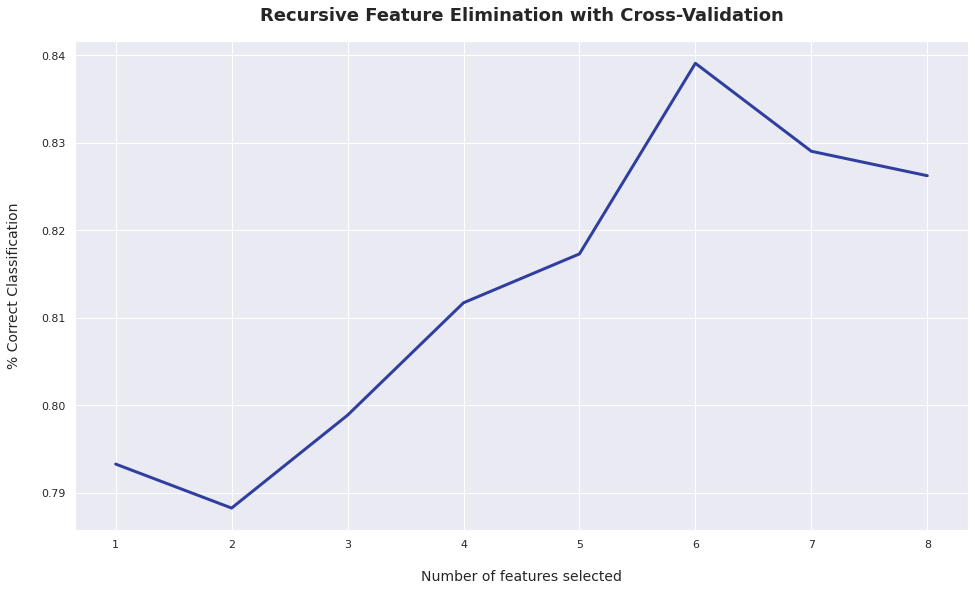

In [39]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfe_CAT.grid_scores_) + 1), rfe_CAT.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

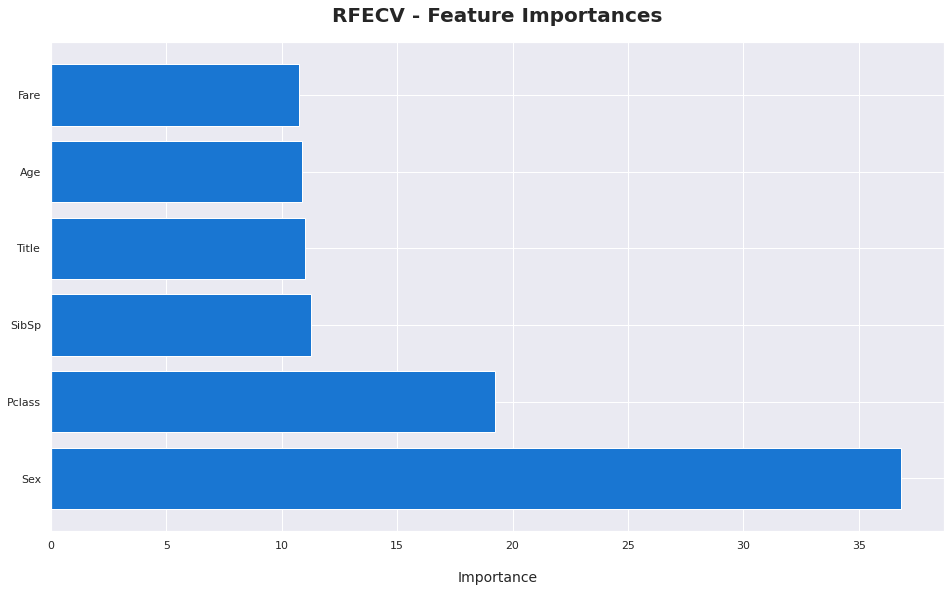

In [40]:
#create dataframe with feature importances:
df_feature_importance=pd.DataFrame()

df_feature_importance['xfre_features'] = x_rfe_features
df_feature_importance['xfre_importance'] = rfe_CAT.estimator_.feature_importances_

#sort values
df_feature_importance = df_feature_importance.sort_values(by='xfre_importance', ascending=False)

#plot
plt.figure(figsize=(16, 9))
plt.barh(y=df_feature_importance['xfre_features'], width=df_feature_importance['xfre_importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show() 

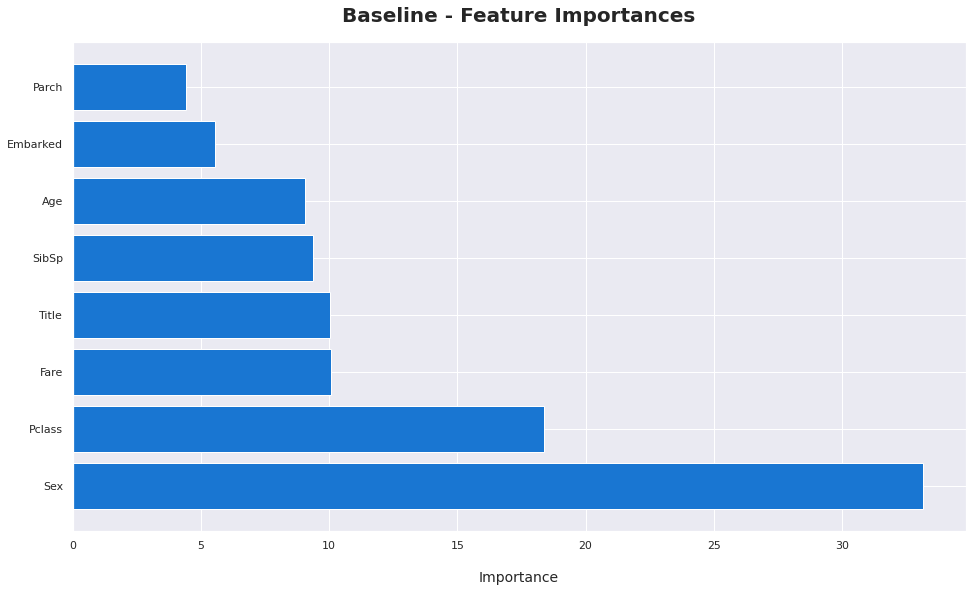

In [41]:
from catboost import Pool
CAT_baseline_pool = Pool(data_enc[x_features], data_enc[Target])
df_feature_importance_baseline=pd.DataFrame()
df_feature_importance_baseline['x_baseline_features'] = x_features
df_feature_importance_baseline['x_baseline_importance']=CAT_baseline.get_feature_importance(CAT_baseline_pool)

#sort values
df_feature_importance_baseline = df_feature_importance_baseline.sort_values(by='x_baseline_importance', ascending=False)

#plot
plt.figure(figsize=(16, 9))
plt.barh(y=df_feature_importance_baseline['x_baseline_features'], width=df_feature_importance_baseline['x_baseline_importance'], color='#1976D2')
plt.title('Baseline - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show() 

In [42]:
#Validate and Impliment

In [43]:
MLA_predict

,Survived,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier,GaussianProcessClassifier,BernoulliNB,GaussianNB,KNeighborsClassifier,SVC,DecisionTreeClassifier,ExtraTreeClassifier,XGBClassifier,CatBoostClassifier
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,0,0,0,0,1,1,1,1,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0,0,0,0,0,0,0
887,1,1,1,1,1,1,1,1,1,1,1,1,1,1
888,0,0,0,0,0,0,1,1,0,1,0,0,0,0
889,1,1,0,0,0,0,1,1,0,0,0,0,0,0


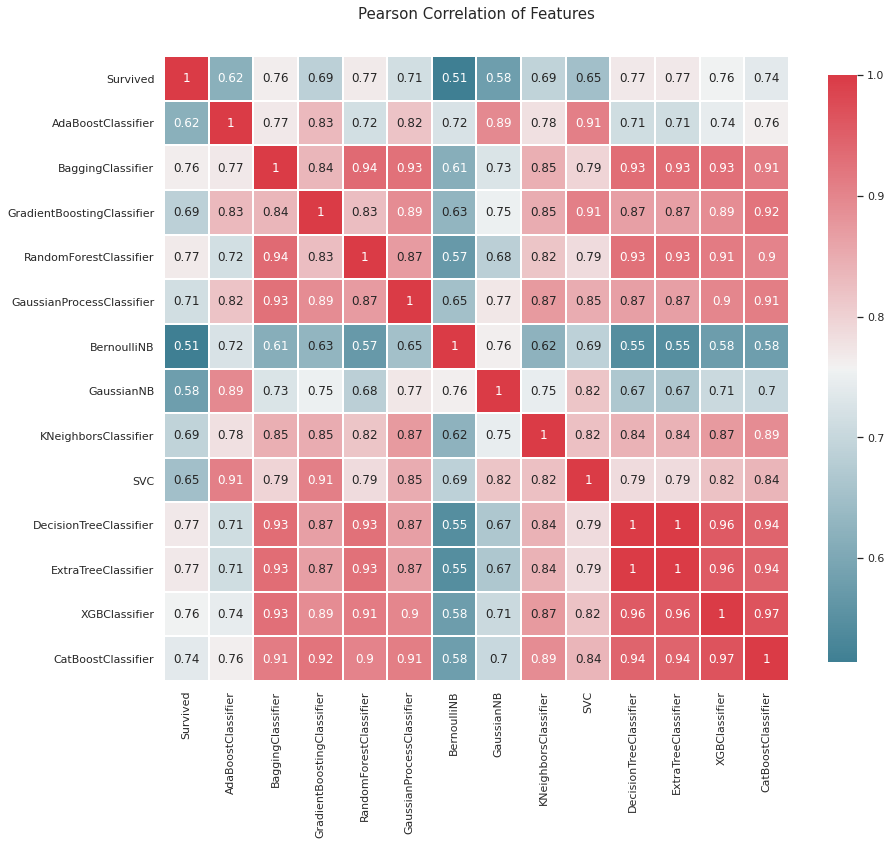

In [44]:
#compare algorithm predictions with each other, where 1 = exactly similar and 0 = exactly opposite
#there are some 1's, but enough blues and light reds to create a "super algorithm" by combining them

correlation_heatmap(MLA_predict)

# Normally we would want to implement a Grid Search or Random Search or Bayes Search to tune Hyperparameter

Ignoring it in this example...focusing on other topics

In [45]:
#1. Model Essembling with Voting Classifier-with timers
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html

#Hard Voting. Predict the class with the largest sum of votes from models
#Soft Voting. Predict the class with the largest summed probability from models.

#key is to remove models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model/poor accuraccies

testscores=[]

def ensembles(features):
    
    vote_est = [
        ('ada', ensemble.AdaBoostClassifier()),
        ('bc', ensemble.BaggingClassifier()),
        #('etc',ensemble.ExtraTreesClassifier()),
        ('gbc', ensemble.GradientBoostingClassifier()),
        ('rfc', ensemble.RandomForestClassifier()),
        ('gpc', gaussian_process.GaussianProcessClassifier()),
        #('bnb', naive_bayes.BernoulliNB()),
        #('gnb', naive_bayes.GaussianNB()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('svc', svm.SVC(probability=True)),
        ('xgb', XGBClassifier(verbosity=0)),
        ('cat', CatBoostClassifier(logging_level='Silent'))
    ]

    #Hard Vote or majority rules

    start_hard = time.perf_counter()

    vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
    vote_hard_cv = model_selection.cross_validate(vote_hard, data_enc[features], data_enc[Target], cv  = cv_split,return_train_score=True)
    vote_hard.fit(data_enc[features], data_enc[Target])

    run_hard = time.perf_counter() - start_hard

    print("Hard Voting Training score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
    print("Hard Voting Test score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
    print("Hard Voting Test score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
    print('Total ensemble time was {:.2f} minutes.'.format(run_hard/60))
    print('-'*10)
    
    testscores.append(vote_hard_cv['test_score'].mean()*100)

    #Soft Vote or weighted probabilities

    start_soft = time.perf_counter()

    vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
    vote_soft_cv = model_selection.cross_validate(vote_soft, data_enc[features], data_enc[Target], cv  = cv_split,return_train_score=True)
    vote_soft.fit(data_enc[features], data_enc[Target])

    run_soft = time.perf_counter() - start_soft

    print("Soft Voting Training score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
    print("Soft Voting Test score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
    print("Soft Voting Test score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
    print('Total ensemble time was {:.2f} minutes.'.format(run_soft/60))
    print('-'*10)
    
    testscores.append(vote_soft_cv['test_score'].mean()*100)

    #2. Model Essembling with Stacking Classifier

    stack_est = [
        ('ada', ensemble.AdaBoostClassifier()),
        ('bc', ensemble.BaggingClassifier()),
        #('etc',ensemble.ExtraTreesClassifier()),
        ('gbc', ensemble.GradientBoostingClassifier()),
        ('rfc', ensemble.RandomForestClassifier()),
        ('gpc', gaussian_process.GaussianProcessClassifier()),
        #('bnb', naive_bayes.BernoulliNB()),
        #('gnb', naive_bayes.GaussianNB()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('svc', svm.SVC(probability=True)),
        ('xgb', XGBClassifier(verbosity=0)),
        ('cat', CatBoostClassifier(logging_level='Silent'))
    ]

    start_stack= time.perf_counter()

    from sklearn.ensemble import StackingClassifier
    from sklearn.linear_model import LogisticRegression
    stack_clf = StackingClassifier(estimators=stack_est, final_estimator=LogisticRegression())
    stack_cv = model_selection.cross_validate(stack_clf, data_enc[features], data_enc[Target], cv  = cv_split,return_train_score=True)
    stack_clf.fit(data_enc[features], data_enc[Target])

    run_stack = time.perf_counter() - start_stack

    print("Staking Training score mean: {:.2f}". format(stack_cv['train_score'].mean()*100)) 
    print("Stacking Test score mean: {:.2f}". format(stack_cv['test_score'].mean()*100))
    print("Stacking Test score 3*std: +/- {:.2f}". format(stack_cv['test_score'].std()*100*3))
    print('Total ensemble time was {:.2f} minutes.'.format(run_stack/60))
    print('-'*10)
    
    testscores.append(stack_cv['test_score'].mean()*100)
    
    
#3 Collect Data

#x_features_testscores=[]
#x_features_rfe_testscores=[]
test_score_enesmbles=pd.DataFrame(columns = ['Hard Voting Classifer','Soft Voting Classifier','Stacking Classifier'])

#

start_total= time.perf_counter()
print("Enesmebling with baseline features, x_features:")
ensembles(x_features)

#x_features_testscores.extend([vote_hard_cv['test_score'].mean()*100,vote_soft_cv['test_score'].mean()*100,stack_cv['test_score'].mean()*100])
x_feature_row = pd.Series(data={'Hard Voting Classifer':testscores[0],
                                'Soft Voting Classifier':testscores[1],
                                'Stacking Classifier':testscores[2]},
                                name='x_features test scores')
#
print("Enesmebling with baseline features, x_rfe_features:")
ensembles(x_rfe_features)
run_total = time.perf_counter() - start_total

#x_features_rfe_testscores.extend([vote_hard_cv['test_score'].mean()*100,vote_soft_cv['test_score'].mean()*100,stack_cv['test_score'].mean()*100])
x_rfe_features_row = pd.Series(data={'Hard Voting Classifer':testscores[3],
                                'Soft Voting Classifier':testscores[4],
                                'Stacking Classifier':testscores[5]},
                                name='x_features test scores')

#
test_score_enesmbles=test_score_enesmbles.append(x_feature_row, ignore_index=False)
test_score_enesmbles=test_score_enesmbles.append(x_rfe_features_row, ignore_index=False)

#
print('Net ensemble time was {:.2f} minutes.'.format(run_total/60))

Enesmebling with baseline features, x_features:
Hard Voting Training score mean: 87.99
Hard Voting Test score mean: 82.79
Hard Voting Test score 3*std: +/- 7.49
Total ensemble time was 0.33 minutes.
----------
Soft Voting Training score mean: 88.35
Soft Voting Test score mean: 83.07
Soft Voting Test score 3*std: +/- 6.18
Total ensemble time was 0.37 minutes.
----------
Staking Training score mean: 86.28
Stacking Test score mean: 83.24
Stacking Test score 3*std: +/- 6.91
Total ensemble time was 1.65 minutes.
----------
Enesmebling with baseline features, x_rfe_features:
Hard Voting Training score mean: 86.57
Hard Voting Test score mean: 84.25
Hard Voting Test score 3*std: +/- 8.27
Total ensemble time was 0.34 minutes.
----------
Soft Voting Training score mean: 86.76
Soft Voting Test score mean: 84.36
Soft Voting Test score 3*std: +/- 6.14
Total ensemble time was 0.37 minutes.
----------
Staking Training score mean: 86.10
Stacking Test score mean: 83.41
Stacking Test score 3*std: +/- 7.

In [46]:
test_score_enesmbles

,Hard Voting Classifer,Soft Voting Classifier,Stacking Classifier
x_features test scores,82.793296,83.072626,83.240223
x_features test scores,84.245810,84.357542,83.407821


In [47]:
#Use the best test score from the above table:

vote_est_submit = [
        ('ada', ensemble.AdaBoostClassifier()),
        ('bc', ensemble.BaggingClassifier()),
        #('etc',ensemble.ExtraTreesClassifier()),
        ('gbc', ensemble.GradientBoostingClassifier()),
        ('rfc', ensemble.RandomForestClassifier()),
        ('gpc', gaussian_process.GaussianProcessClassifier()),
        #('bnb', naive_bayes.BernoulliNB()),
        #('gnb', naive_bayes.GaussianNB()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('svc', svm.SVC(probability=True)),
        ('xgb', XGBClassifier(verbosity=0)),
        ('cat', CatBoostClassifier(logging_level='Silent'))
        ]

vote_soft_submit= ensemble.VotingClassifier(estimators = vote_est_submit , voting = 'soft')
vote_soft_submit.fit(data_enc[x_rfe_features], data_enc[Target])

# Predicting the Test set results to submit to Kaggle
y_test_submit = vote_soft_submit.predict(X_test_enc[x_rfe_features])
print(y_test_submit)

[0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [48]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test_submit})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
